In [3]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import dustmaps.bayestar
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.io import fits, ascii
from dustmaps.config import config
config.reset()

In [4]:
# Function to call coordinates and return distance axis and differential Av. To get total Av along a line a sight try np.sum(cdusts)*delta(dists).

def dust(l, b):
    # Return distance, differential Av along a line of sight provided:
    dists = np.linspace(100, 15000, 100)
    cdusts = np.zeros_like(dists)
    for i, d in enumerate(dists):
        if (i != 0): 
            point = SkyCoord(l*u.deg, b*u.deg, distance=d*u.pc, frame='galactic')
            data, flags = b19.query(point, mode='mean', return_flags=True)
            cdusts[i]=data
    dists = dists/1000
    cdusts = cdusts-np.roll(cdusts, 1)
    return dists, cdusts

In [5]:
# You may have to download this map and it will take a long time. See dustmaps documentation.
import dustmaps.bayestar
dustmaps.bayestar.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [6]:
def distmod_to_dist(distmod):
    return 10**(1 + distmod / 5)
# Change modulus to distance

In [7]:
# Load the Bayestar 19 dustmap
b19 = dustmaps.bayestar.BayestarQuery(max_samples=2, version='bayestar2019')

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 15.359 s
  pix_info:   0.367 s
   samples:   5.259 s
      best:   2.518 s
       nan:   0.029 s
      sort:   7.109 s
       idx:   0.076 s


In [8]:
# Coordinates to be called from Bayestar 2019
l = 119.07
b = 28

(0.0, 10.0)

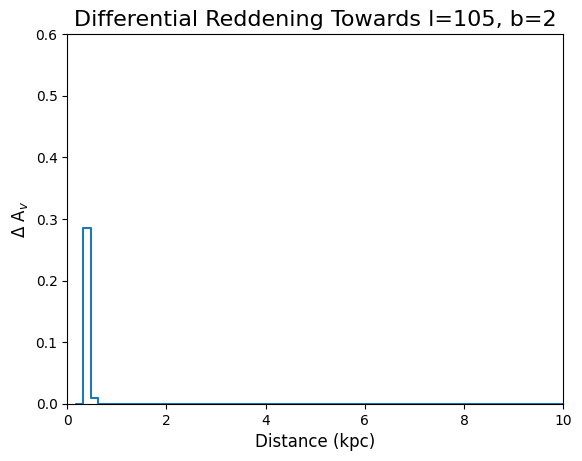

In [9]:
# Grab the kpc, Av data for a given point:
dists, cdusts = dust(l,b)

# Plot the given point:
fig, axs = plt.subplots(1, sharex='all')

# Plot the Dust:
axs.step(dists, cdusts, where='mid')
axs.set_xlabel('Distance (kpc)', size=12)
axs.set_ylabel(r'$\Delta$ A$_{v}$', size=12)
axs.set_title("Differential Reddening Towards l=105, b=2", size=16)
axs.set_ylim([0, 0.6])
axs.set_xlim([0, 10])

In [17]:
def plotred(l, b):
    """Plot the differential reddening for a given Galactic coordinate (l, b)."""
    dists, cdusts = dust(l, b)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.step(dists, cdusts, where='mid')
    ax.set_xlabel('Distance (kpc)', size=12)
    ax.set_ylabel(r'$\Delta$ A$_{\mathrm{v}}$', size=12)
    ax.set_title(f'Differential Av Towards l={l}, b={b}', size=12)
    ax.set_xlim([0, 2.5])
    ax.set_ylim([0, 0.6])
    
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
    max_Av = np.max(cdusts)
    print('Max Av is', max_Av)
    print('Max Av is at distance', dists[np.where(cdusts == max_Av)], 'kpc')
        

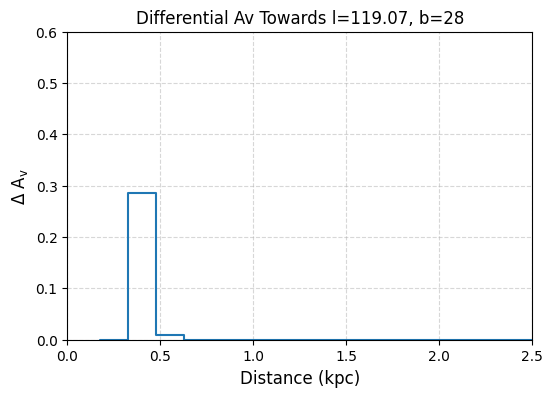

Max Av is 0.28563106060028076
Max Av is at distance [0.4010101] kpc


In [18]:
plotred(119.07, 28)

In [19]:
def plotdustspec(l, b):
    fig, ax = plt.subplots(figsize = (8, 6))
    OH67 = ascii.read('CODarkDustmaps/OH67basesubbed/OH' + str(l) + 'p' + str(b) + '_67basesub.txt')
    OH65 = ascii.read('CODarkDustmaps/OH65basesubbed/OH' + str(l) + 'p' + str(b) + '_65basesub.txt')
    HI = ascii.read('CODarkDustmaps/HI/HI' + str(l) + 'p' + str(b) + '.txt', data_start = 13, data_end = 167)
    CO = ascii.read('CODarkDustmaps/CO/CO' + str(l) + 'p' + str(b) + '.txt')

    # Extract velocity and temperature (Ta) data
    velHI, TaHI = HI['col1'], HI['col2']
    vel67, Ta67 = OH67['col1'], OH67['col2']
    vel65, Ta65 = OH65['col1'], OH65['col2']
    velCO, TaCO = CO['col1'], CO['col2']

    # Plot data
    ax.step(vel67, Ta67, where='mid', label='OH 1667 MHz')
    ax.step(vel65, Ta65, where='mid', label='OH 1665 MHz')
    ax.step(velHI, TaHI, where='mid', label='HI')
    ax.step(velCO, TaCO, where='mid', label='CO')

    # Labels and formatting
    ax.set_xlabel('Velocity (km/s)', fontsize=10)
    ax.set_ylabel('Brightness Temperature (K)', fontsize=10)
    ax.set_title(f'Dust Map at l={l}, b={b}', fontsize=10)
    ax.legend()
    ax.axhline(0, color='black', linewidth=0.8)
    
    # Save and close figure
    fig.tight_layout()
    plt.show()   

#Just gotta separate this into different functions per spectra!

FileNotFoundError: [Errno 2] No such file or directory: 'CODarkDustmaps/OH67basesubbed/OH119070p2800_67basesub.txt'

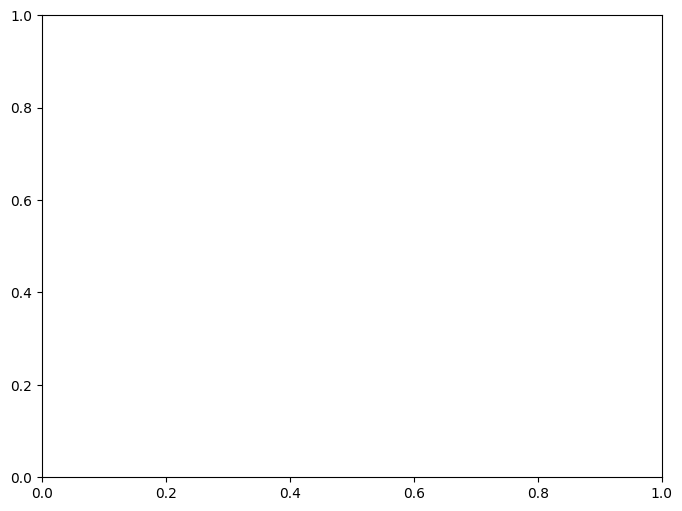

In [20]:
plotdustspec(119070, 2800)

## Encapsulating Function "dustplot"
### This function incorporates the previous "plotred" to plot the spectra along with the differential Av. 
### Av is extinction, which is defined as the total dimming of the light coming directly from a point source caused by both photon scattering and photon absorption (Essential Radio Astronomy, see ERA sec 2.8)

In [28]:
def dustplot(l, b, l2, b2):
    fig, ax = plt.subplots()
    #CODarkDustmaps/OH67basesubbed/OH119210p2000_67basesub.txt
    OH67 = ascii.read('OH67basesubbed/OH' + str(l) + 'p' + str(b) + '_67basesub.txt')

    # Extract velocity and temperature (Ta) data
    vel67, Ta67 = OH67['col1'], OH67['col2']
    # Plot data
    ax.step(vel67, Ta67, where='mid', label='OH 1667 MHz')

    # Labels and formatting
    ax.set_xlabel('Velocity (km/s)', fontsize=10)
    ax.set_ylabel(r'$T_{mb}$', fontsize=10)
    ax.set_title(f'OH67 Spectra: l={l}, b={b}', fontsize=10)
    ax.legend()
    ax.axhline(0)
    ax.axhline(0.003, ls='dashed')
    ax.axhline(-0.003, ls='dashed')
    plotred(l2, b2)
    
    #show that thang!
    fig.tight_layout()
    plt.show()   

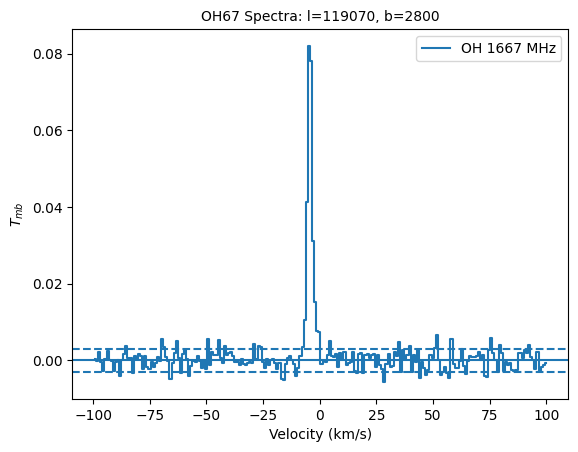

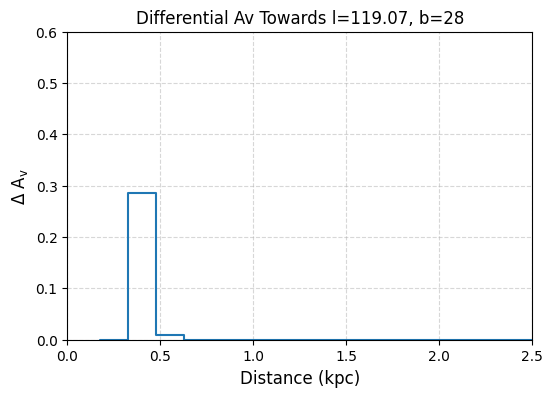

Max Av is 0.28563106060028076
Max Av is at distance [0.4010101] kpc


In [29]:
dustplot(119070, 2800, 119.07, 28)

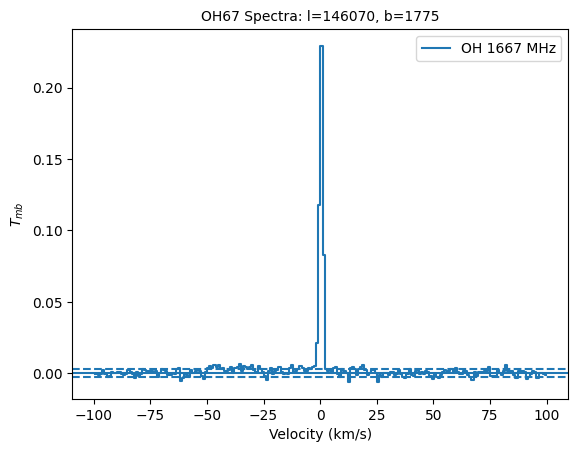

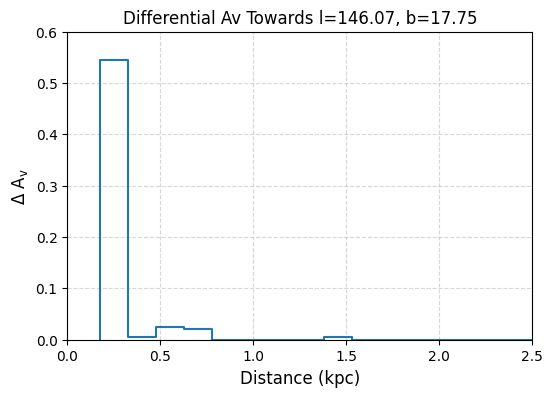

Max Av is 0.5449999570846558
Max Av is at distance [0.25050505] kpc


In [30]:
dustplot(146070, 1775, 146.07, 17.75)

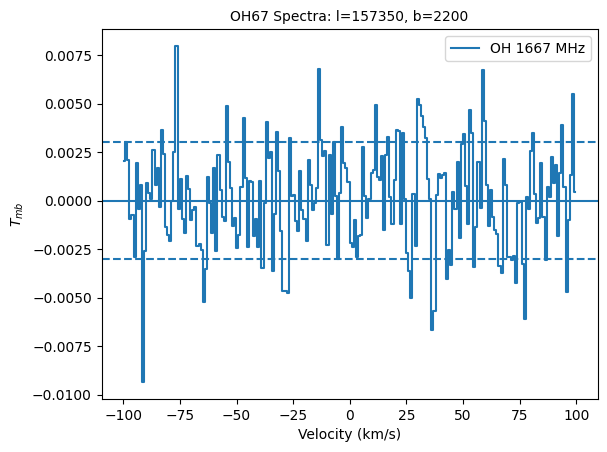

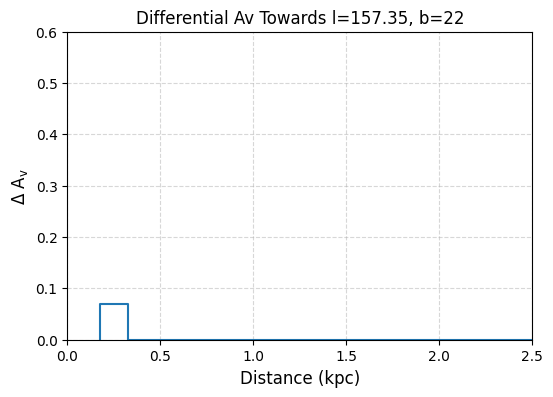

Max Av is 0.07000000029802322
Max Av is at distance [0.25050505] kpc


In [31]:
dustplot(157350, 2200, 157.35, 22)

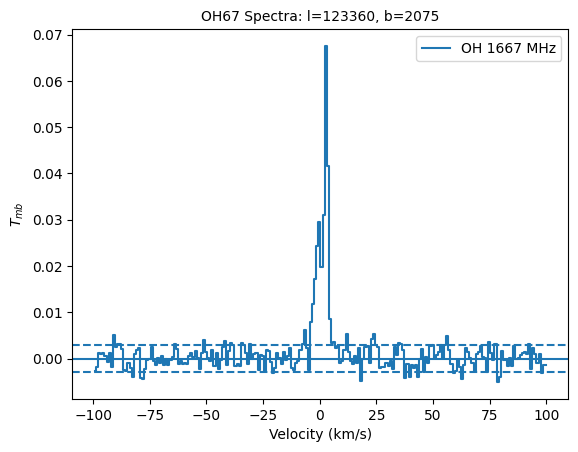

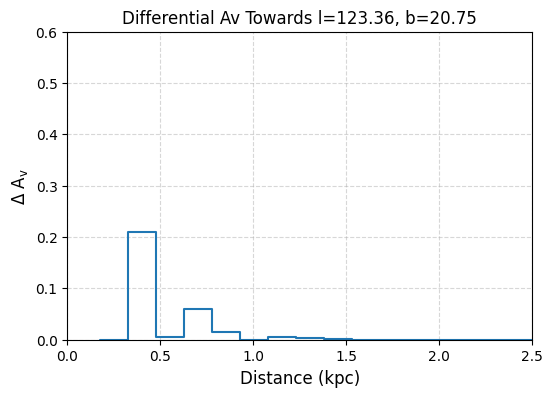

Max Av is 0.20999999344348907
Max Av is at distance [0.4010101] kpc


In [32]:
dustplot(123360, 2075, 123.36, 20.75)